# 08 - DS EDA, Segmentation, Préprocessing et Feature Engineering

Objectif: justifier les transformations et les features à partir d'observations statistiques et métier.


**Convention de commentaire dans ce notebook (à respecter dans l'analyse)**

- `Constat` : ce que montrent les chiffres/graphes
- `Interprétation` : ce que cela signifie (avec prudence)
- `Décision` : impact pratique sur preprocessing / CV / modèle
- Terminer chaque bloc par une phrase `Impact modèle attendu`


In [5]:
import sys
import json
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from src.v2_pipeline import ensure_dir

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

ROOT = Path.cwd()
if not (ROOT / "src").exists():
    ROOT = ROOT.parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src import v2_pipeline as v2
from src.ds_analysis_utils import *

DATA_DIR = ROOT / "data"
ARTIFACT_DS = ensure_dir(ROOT / DEFAULT_DS_DIR)
ARTIFACT_V2 = ROOT / v2.DEFAULT_V2_DIR

SEED = 42
QUICK_ANALYSIS = True
FULL_ANALYSIS = False
SAMPLE_N = 3000
np.random.seed(SEED)


In [6]:
train_raw, test_raw = load_project_datasets(DATA_DIR)
print("train:", train_raw.shape, "test:", test_raw.shape)
display(train_raw.head(2))
display(test_raw.head(2))


train: (50000, 33) test: (50000, 28)


,index,id_client,id_vehicule,id_contrat,bonus,type_contrat,duree_contrat,anciennete_info,freq_paiement,paiement,...,marque_vehicule,modele_vehicule,debut_vente_vehicule,fin_vente_vehicule,vitesse_vehicule,type_vehicule,prix_vehicule,poids_vehicule,nombre_sinistres,montant_sinistre
0,0,A00000001,V01,A00000001-V01,0.5,Maxi,29,9,Biannual,No,...,PEUGEOT,306,10,9,182,Tourism,20700,1210,0,0.0
1,1,A00000002,V01,A00000002-V01,0.5,Maxi,3,1,Biannual,No,...,MERCEDES BENZ,C220,4,2,229,Tourism,34250,1510,0,0.0


,index,bonus,type_contrat,duree_contrat,anciennete_info,freq_paiement,paiement,utilisation,code_postal,conducteur2,...,din_vehicule,essence_vehicule,marque_vehicule,modele_vehicule,debut_vente_vehicule,fin_vente_vehicule,vitesse_vehicule,type_vehicule,prix_vehicule,poids_vehicule
0,50000,0.58,Maxi,1,1,Yearly,No,Retired,28388,No,...,55,Gasoline,RENAULT,CLIO,16,15,150,Tourism,10321,830
1,50001,0.50,Median2,2,2,Yearly,No,Retired,19123,No,...,96,Diesel,MERCEDES BENZ,C220,16,12,175,Tourism,24652,1400


In [7]:
feature_sets = v2.prepare_feature_sets(train_raw, test_raw, rare_min_count=30, drop_identifiers=True)
bundle = feature_sets["base_v2"]
print("feature sets:", {k: (len(v.feature_cols), len(v.cat_cols), len(v.num_cols)) for k, v in feature_sets.items()})


feature sets: {'base_v2': (47, 18, 29), 'robust_v2': (44, 15, 29), 'compact_v2': (43, 14, 29)}


In [8]:
# Typage enrichi + cardinalité
data_dict = build_data_dictionary(train_raw, test_raw)
col_types = classify_columns(train_raw, test_raw)
cardinality = build_cardinality_report(train_raw, test_raw)
display(col_types)
display(cardinality.head(25))


,column,present_train,present_test,dtype_train,dtype_test,nunique_train,nunique_test,missing_rate_train,missing_rate_test,sample_values_train,role_guess,is_target,is_id_like,is_categorical,is_numeric,high_cardinality_train
0,code_postal,1,1,object,object,12790,12806.0,0.00000,0.00000,36233 | 92073 | 92026,categorical,0,0,1,0,1
1,conducteur2,1,1,object,object,2,2.0,0.00000,0.00000,No | No | No,categorical,0,0,1,0,0
2,essence_vehicule,1,1,object,object,3,3.0,0.00000,0.00000,Gasoline | Diesel | Gasoline,categorical,0,0,1,0,0
3,freq_paiement,1,1,object,object,4,4.0,0.00000,0.00000,Biannual | Biannual | Yearly,categorical,0,0,1,0,0
4,marque_vehicule,1,1,object,object,89,88.0,0.00000,0.00000,PEUGEOT | MERCEDES BENZ | BMW,categorical,0,0,1,0,0
5,modele_vehicule,1,1,object,object,886,894.0,0.00000,0.00000,306 | C220 | Z3,categorical,0,0,1,0,1
6,paiement,1,1,object,object,2,2.0,0.00000,0.00000,No | No | No,categorical,0,0,1,0,0
7,sex_conducteur1,1,1,object,object,2,2.0,0.00000,0.00000,M | M | M,categorical,0,0,1,0,0
8,sex_conducteur2,1,1,object,object,3,3.0,0.66812,0.66816,F | M | F,categorical,0,0,1,0,0
9,type_contrat,1,1,object,object,4,4.0,0.00000,0.00000,Maxi | Maxi | Maxi,categorical,0,0,1,0,0


,column,dtype_train,nunique_train,nunique_test,top1_ratio_train,rare_ratio_train_lt10
0,index,int64,50000,50000.0,0.00002,1.000000
1,id_contrat,object,50000,NaN,0.00002,1.000000
2,id_client,object,45785,NaN,0.00010,1.000000
3,code_postal,object,12790,12806.0,0.00490,0.928225
4,prix_vehicule,int64,4752,4691.0,0.01014,0.780934
5,montant_sinistre,float64,2260,NaN,0.94166,0.996018
6,poids_vehicule,int64,968,959.0,0.03766,0.501033
7,modele_vehicule,object,886,894.0,0.07214,0.586907
8,cylindre_vehicule,int64,532,521.0,0.06476,0.535714
9,din_vehicule,int64,207,205.0,0.09224,0.352657


In [9]:
# Statistiques univariées numériques
num_cols = [c for c in train_raw.columns if str(train_raw[c].dtype).startswith(("int","float"))]
num_cols_eda = [c for c in num_cols if c not in [v2.TARGET_FREQ_COL]]
rows = []
for c in num_cols_eda:
    s = pd.to_numeric(train_raw[c], errors="coerce").replace([np.inf,-np.inf], np.nan).dropna()
    if len(s) == 0:
        continue
    rows.append({
        "column": c,
        "n": int(len(s)),
        "mean": float(s.mean()),
        "median": float(s.median()),
        "std": float(s.std(ddof=0)),
        "iqr": float(s.quantile(0.75) - s.quantile(0.25)),
        "mad": float(np.median(np.abs(s - s.median()))),
        "skew": float(stats.skew(s)) if len(s) > 2 else np.nan,
        "kurtosis": float(stats.kurtosis(s)) if len(s) > 3 else np.nan,
        "p01": float(s.quantile(0.01)),
        "p05": float(s.quantile(0.05)),
        "p50": float(s.quantile(0.50)),
        "p95": float(s.quantile(0.95)),
        "p99": float(s.quantile(0.99)),
    })
uni_num = pd.DataFrame(rows).sort_values("skew", ascending=False)
display(uni_num.head(20))


,column,n,mean,median,std,iqr,mad,skew,kurtosis,p01,p05,p50,p95,p99
16,montant_sinistre,50000,103.369344,0.0,545.397425,0.0,0.0,10.146564,187.028429,0.00,0.00,0.0,764.236,2683.76
1,bonus,50000,0.537911,0.5,0.098998,0.0,0.0,3.440619,14.650131,0.50,0.50,0.5,0.760,0.95
7,anciennete_permis2,50000,9.139800,0.0,17.059321,15.0,0.0,2.567973,9.186628,0.00,0.00,0.0,43.000,59.00
3,anciennete_info,50000,2.726860,2.0,2.348535,2.0,1.0,2.438832,8.324153,1.00,1.00,2.0,7.000,12.00
14,prix_vehicule,50000,18095.562080,16250.0,8715.016777,10200.0,4800.0,2.027298,10.586471,3771.00,8522.00,16250.0,33450.000,47900.00
11,debut_vente_vehicule,50000,11.628320,10.0,7.756015,9.0,4.0,1.663858,4.741198,1.00,2.00,10.0,27.000,41.00
10,din_vehicule,50000,91.547520,87.0,34.489591,41.0,21.0,1.634912,6.225890,30.00,51.00,87.0,150.000,210.00
8,anciennete_vehicule,49999,9.531091,8.0,7.012082,9.0,4.0,1.472460,4.035710,1.00,1.00,8.0,22.000,33.00
12,fin_vente_vehicule,50000,8.653180,7.0,6.619835,8.0,4.0,1.374192,3.453905,1.00,1.00,7.0,21.000,30.00
9,cylindre_vehicule,50000,1647.795820,1587.0,463.643996,550.0,309.0,1.199923,5.450556,652.00,998.00,1587.0,2477.000,2993.00


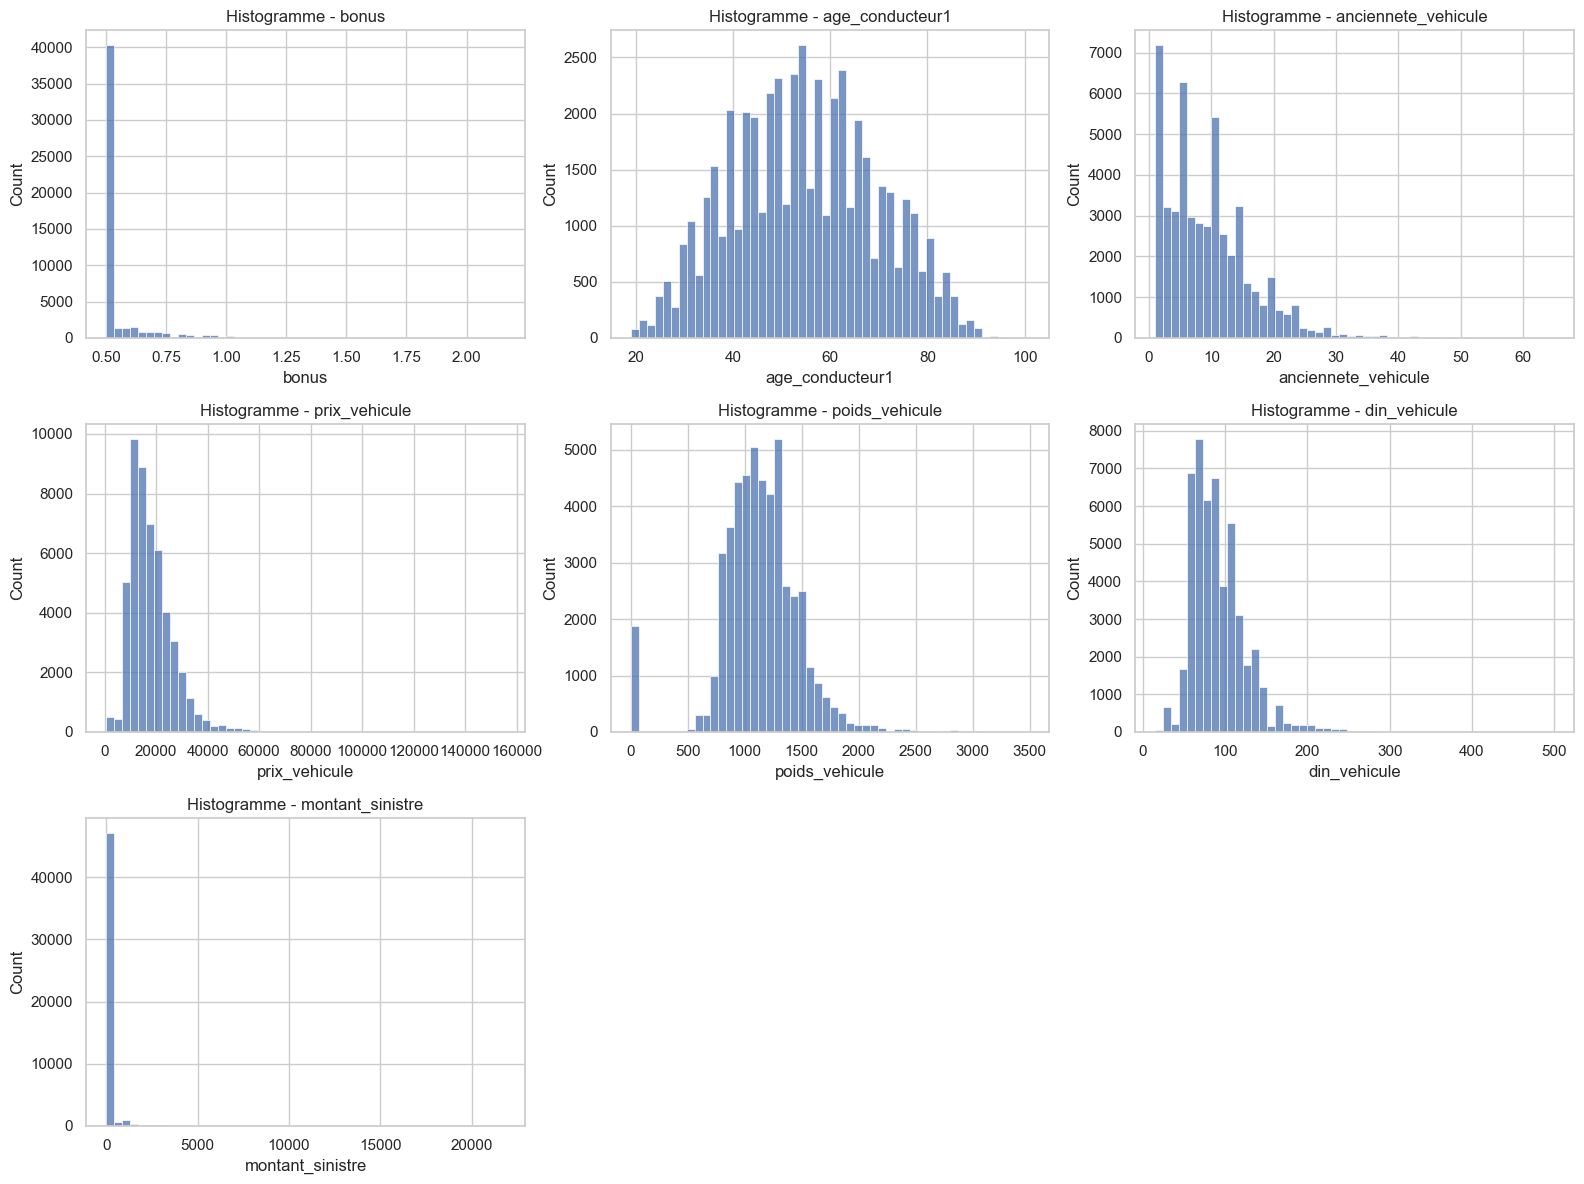

In [10]:
# Visualisations univariées (échantillon de variables numériques)
plot_num_cols = [c for c in ["bonus","age_conducteur1","anciennete_vehicule","prix_vehicule","poids_vehicule","din_vehicule",v2.TARGET_SEV_COL] if c in train_raw.columns]
ncols = 3
nrows = int(np.ceil(len(plot_num_cols) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4 * nrows))
axes = np.array(axes).reshape(-1)
for ax, c in zip(axes, plot_num_cols):
    s = pd.to_numeric(train_raw[c], errors='coerce')
    sns.histplot(s, bins=50, ax=ax)
    ax.set_title(f"Histogramme - {c}")
for ax in axes[len(plot_num_cols):]:
    ax.axis("off")
plt.tight_layout()


**À commenter (univarié)**
- `Constat`: asymétrie, valeurs extrêmes, distributions tronquées.
- `Interprétation`: impact sur choix de métriques et transformations.
- `Décision`: `log1p`, winsorisation d'apprentissage, modèles robustes.


In [11]:
# Statistiques catégorielles + rareté
cat_cols = [c for c in train_raw.columns if train_raw[c].dtype == "object"]
cat_rows = []
for c in cat_cols:
    vc = train_raw[c].astype(str).value_counts(dropna=False)
    cat_rows.append({
        "column": c,
        "nunique": int(vc.size),
        "top1": str(vc.index[0]) if len(vc) else "",
        "top1_ratio": float(vc.iloc[0] / max(len(train_raw), 1)) if len(vc) else np.nan,
        "rare_levels_lt10": int((vc < 10).sum()),
        "rare_levels_ratio_lt10": float((vc < 10).sum() / max(len(vc), 1)) if len(vc) else np.nan,
    })
cat_stats = pd.DataFrame(cat_rows).sort_values("nunique", ascending=False)
display(cat_stats)


,column,nunique,top1,top1_ratio,rare_levels_lt10,rare_levels_ratio_lt10
2,id_contrat,50000,A00000001-V01,0.00002,50000,1.000000
0,id_client,45785,A00033051,0.00010,45785,1.000000
7,code_postal,12790,31555,0.00490,11872,0.928225
13,modele_vehicule,886,CLIO,0.07214,520,0.586907
12,marque_vehicule,89,RENAULT,0.26634,38,0.426966
1,id_vehicule,5,V01,0.91570,1,0.200000
3,type_contrat,4,Maxi,0.64720,0,0.000000
4,freq_paiement,4,Yearly,0.37896,0,0.000000
6,utilisation,4,WorkPrivate,0.65882,0,0.000000
11,essence_vehicule,3,Diesel,0.54952,0,0.000000


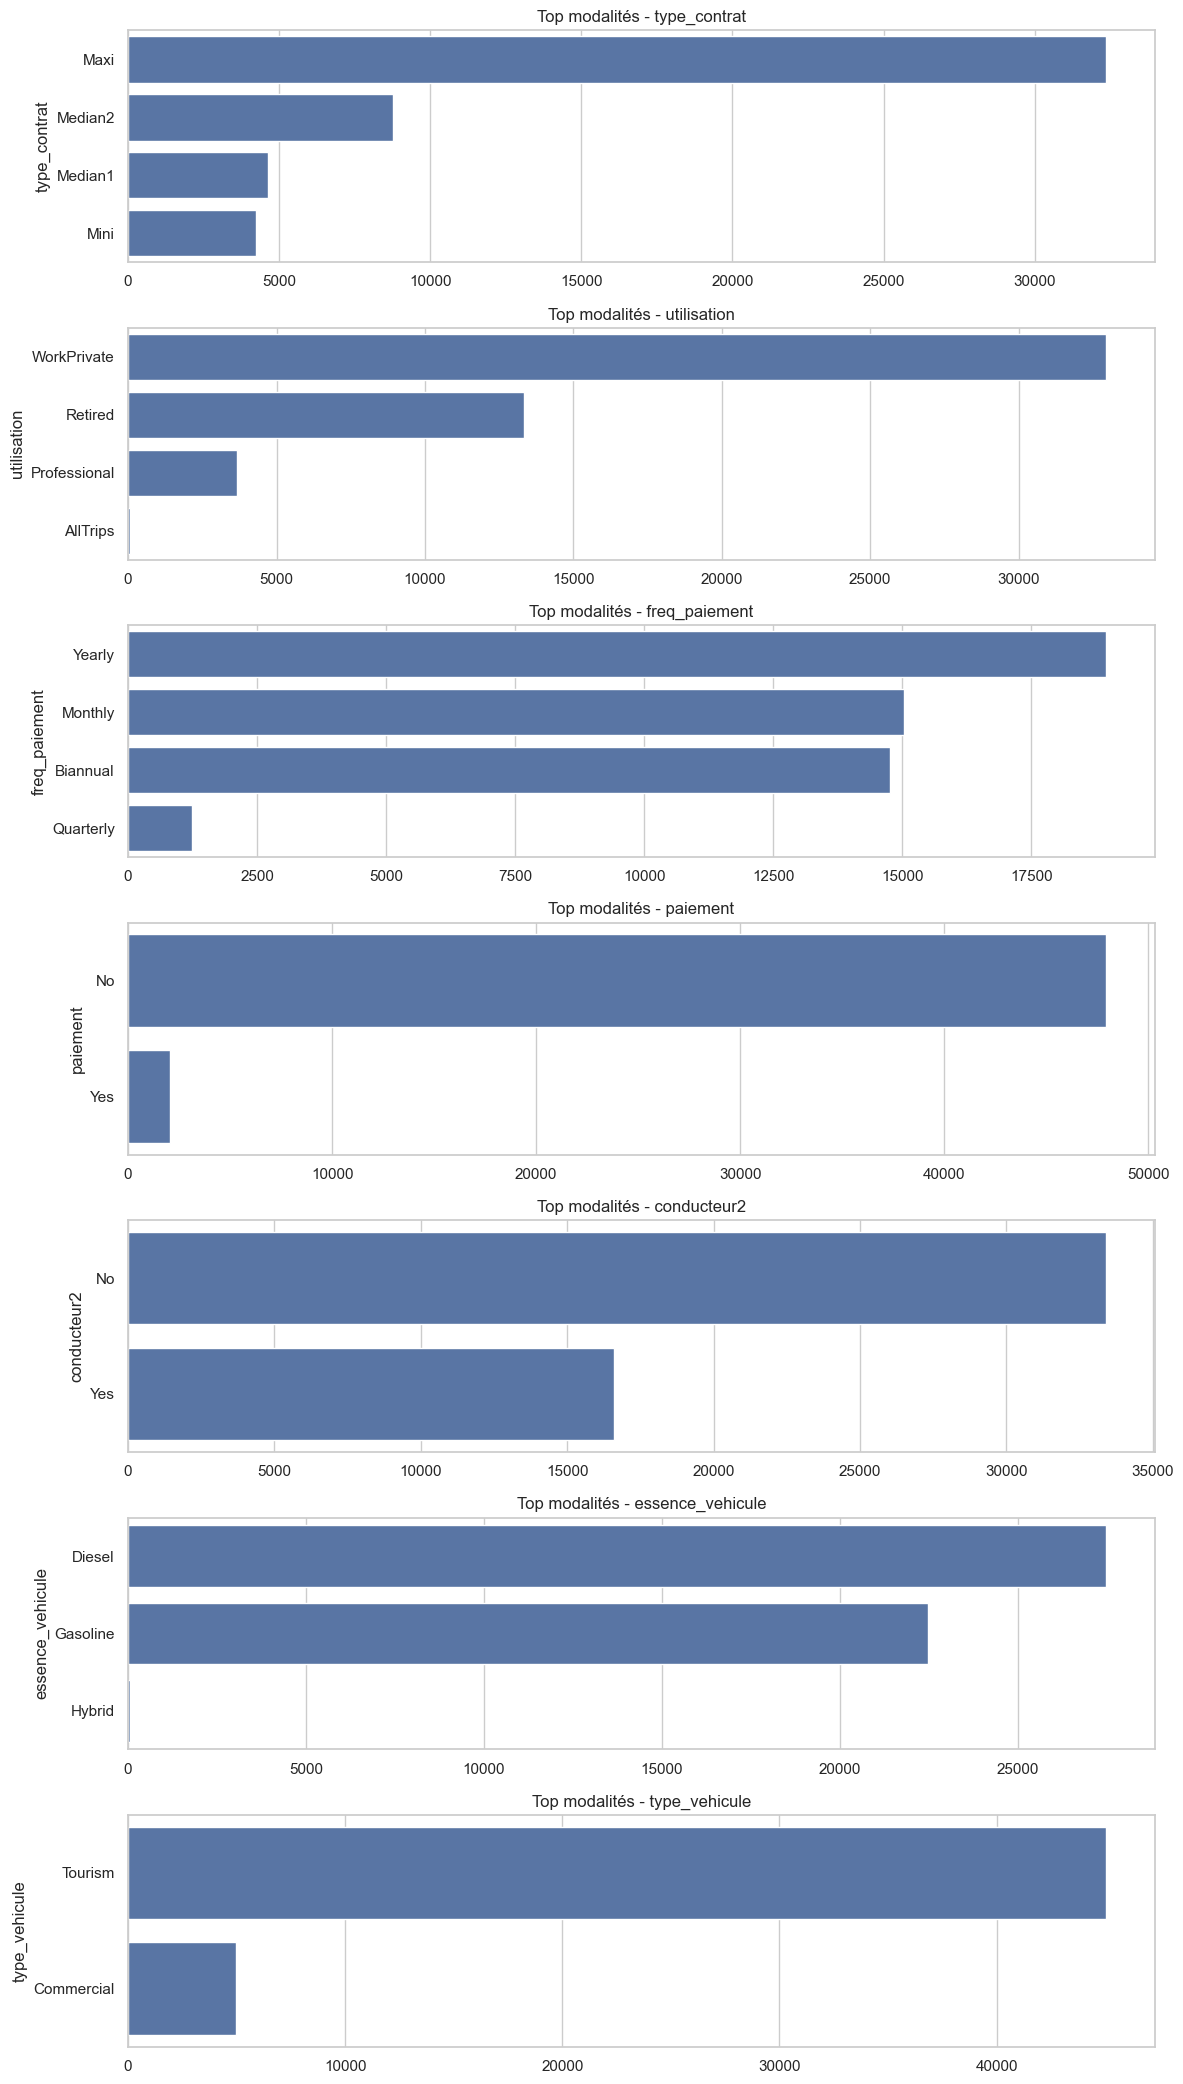

In [12]:
# Barplots catégorielles (fréquences)
plot_cat_cols = [c for c in ["type_contrat","utilisation","freq_paiement","paiement","conducteur2","essence_vehicule","type_vehicule"] if c in train_raw.columns]
fig, axes = plt.subplots(len(plot_cat_cols), 1, figsize=(12, 3 * len(plot_cat_cols)))
if len(plot_cat_cols) == 1:
    axes = [axes]
for ax, c in zip(axes, plot_cat_cols):
    vc = train_raw[c].astype(str).value_counts(dropna=False).head(15)
    sns.barplot(x=vc.values, y=vc.index.astype(str), ax=ax)
    ax.set_title(f"Top modalités - {c}")
plt.tight_layout()


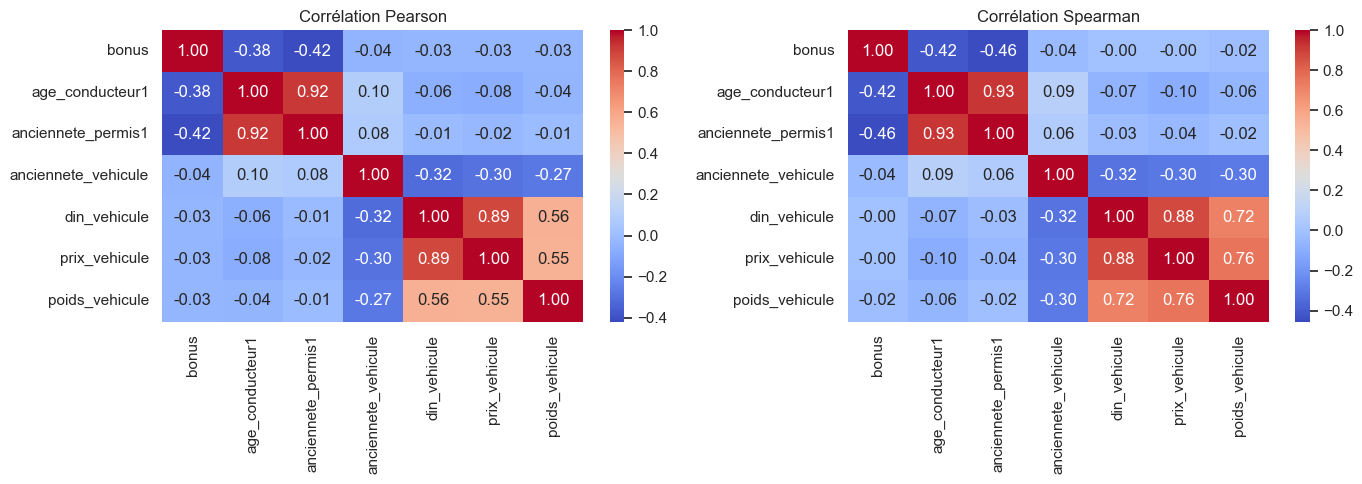

In [13]:
# Analyse bivariée num-num (Pearson / Spearman) sur sous-ensemble
num_subset = [c for c in ["bonus","age_conducteur1","anciennete_permis1","anciennete_vehicule","din_vehicule","prix_vehicule","poids_vehicule"] if c in train_raw.columns]
corr_pearson = train_raw[num_subset].corr(method="pearson")
corr_spearman = train_raw[num_subset].corr(method="spearman")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(corr_pearson, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0])
axes[0].set_title("Corrélation Pearson")
sns.heatmap(corr_spearman, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1])
axes[1].set_title("Corrélation Spearman")
plt.tight_layout()


In [14]:
# Analyse cat-cat (Cramer's V)
cat_subset = [c for c in ["type_contrat","utilisation","freq_paiement","paiement","essence_vehicule","type_vehicule","marque_vehicule"] if c in train_raw.columns]
cramers_v = compute_cramers_v_table(train_raw, cat_cols=cat_subset, max_cols=12)
display(cramers_v.head(20))


,col_a,col_b,cramers_v
0,utilisation,type_vehicule,0.249034
1,type_contrat,type_vehicule,0.247335
2,type_vehicule,marque_vehicule,0.236115
3,essence_vehicule,type_vehicule,0.204121
4,essence_vehicule,marque_vehicule,0.183738
5,utilisation,paiement,0.153309
6,type_contrat,marque_vehicule,0.121215
7,utilisation,freq_paiement,0.117696
8,utilisation,marque_vehicule,0.092623
9,utilisation,essence_vehicule,0.091228


In [15]:
# Analyse cible par segments (fréquence / sévérité / pure premium)
train_fe = v2.add_engineered_features(train_raw.copy())
segment_cols = [c for c in ["utilisation","type_contrat","cp2","cp3","marque_vehicule","type_vehicule"] if c in train_fe.columns]
seg_tables = compute_segment_target_tables(train_fe, segment_cols=segment_cols)
for name, df_seg in seg_tables.items():
    print(f"Segment: {name}")
    display(df_seg.head(10))


Segment: utilisation


,segment_col,segment_value,n,claim_rate,severity_mean_pos,severity_median_pos,severity_q95_pos,severity_q99_pos,pure_premium_obs
0,utilisation,AllTrips,48,0.125000,1362.991667,1286.205,1782.9575,1853.6235,170.373958
1,utilisation,Professional,3667,0.078811,1935.354913,1261.560,5138.8140,7190.3480,152.527289
2,utilisation,Retired,13344,0.060177,1663.779128,1236.000,3877.5620,5340.0402,100.121001
3,utilisation,WorkPrivate,32941,0.055220,1794.918659,1236.000,4492.9490,7503.7066,99.115298


Segment: type_contrat


,segment_col,segment_value,n,claim_rate,severity_mean_pos,severity_median_pos,severity_q95_pos,severity_q99_pos,pure_premium_obs
0,type_contrat,Maxi,32360,0.074815,1845.045171,1296.47,4527.380,7047.8660,138.036290
1,type_contrat,Median1,4638,0.029970,1513.196547,1236.00,3002.464,9309.8296,45.350220
2,type_contrat,Median2,8759,0.032310,1366.859399,1236.00,2971.864,5548.0004,44.162714
3,type_contrat,Mini,4243,0.017440,1411.585270,1236.00,2323.950,6781.8150,24.618739


Segment: cp2


,segment_col,segment_value,n,claim_rate,severity_mean_pos,severity_median_pos,severity_q95_pos,severity_q99_pos,pure_premium_obs
0,cp2,93,747,0.080321,2109.778000,1271.500,5453.6655,9377.4116,169.460080
1,cp2,58,188,0.058511,2682.102727,1492.070,7777.1750,10934.8350,156.931543
2,cp2,70,141,0.070922,2146.534000,1446.800,4643.5215,4901.4723,152.236454
3,cp2,68,610,0.062295,2366.712105,1393.590,5931.9395,12922.5186,147.434525
4,cp2,69,1185,0.078481,1853.430430,1256.100,4662.9400,6720.8012,145.459097
5,cp2,77,908,0.072687,1978.605455,1386.725,4526.4375,5961.4610,143.819339
6,cp2,94,1120,0.076786,1870.087093,1348.015,4139.3825,7514.6105,143.595973
7,cp2,30,506,0.073123,1916.629189,1442.870,3898.3580,6394.1484,140.148775
8,cp2,42,626,0.060703,2289.594737,1387.500,4305.9435,13350.6271,138.984984
9,cp2,06,921,0.066232,2076.012623,1399.140,6766.8200,7730.9500,137.499207


Segment: cp3


,segment_col,segment_value,n,claim_rate,severity_mean_pos,severity_median_pos,severity_q95_pos,severity_q99_pos,pure_premium_obs
0,cp3,863,1,1.000000,1010.410000,1010.410,1010.4100,1010.4100,1010.410000
1,cp3,929,7,0.285714,3168.340000,3168.340,5047.9090,5214.9818,905.240000
2,cp3,872,4,0.250000,3150.820000,3150.820,3150.8200,3150.8200,787.705000
3,cp3,703,20,0.150000,4114.696667,4249.430,4894.3070,4951.6294,617.204500
4,cp3,028,9,0.222222,2374.235000,2374.235,2741.1425,2773.7565,527.607778
5,cp3,459,7,0.285714,1553.260000,1553.260,1838.7940,1864.1748,443.788571
6,cp3,807,43,0.139535,2354.356667,2124.275,4619.4075,5086.5295,328.514884
7,cp3,119,2,0.500000,656.840000,656.840,656.8400,656.8400,328.420000
8,cp3,253,37,0.081081,4038.090000,3809.150,6461.9180,6697.7196,327.412703
9,cp3,090,15,0.200000,1636.916667,1236.000,2513.5590,2627.1198,327.383333


Segment: marque_vehicule


,segment_col,segment_value,n,claim_rate,severity_mean_pos,severity_median_pos,severity_q95_pos,severity_q99_pos,pure_premium_obs
0,marque_vehicule,ARO,2,0.500000,1236.000000,1236.000,1236.0000,1236.0000,618.000000
1,marque_vehicule,ISUZU,11,0.090909,2472.960000,2472.960,2472.9600,2472.9600,224.814545
2,marque_vehicule,VOLVO,268,0.111940,1681.655000,1151.490,4248.4440,5215.9386,188.244963
3,marque_vehicule,JEEP,91,0.087912,1927.261250,1815.475,3251.7670,3554.4414,169.429560
4,marque_vehicule,JAGUAR,44,0.113636,1421.896000,1490.000,2034.6820,2090.3204,161.579091
5,marque_vehicule,MERCEDES BENZ,1529,0.077175,2083.180508,1287.465,5516.8350,9139.3082,160.768672
6,marque_vehicule,CHRYSLER,105,0.104762,1489.185455,1180.580,3261.8550,3788.1790,156.009905
7,marque_vehicule,SUBARU,27,0.074074,2094.585000,2094.585,3051.1005,3136.1241,155.154444
8,marque_vehicule,SUZUKI,399,0.070175,2200.272143,1025.445,6454.9000,12174.5428,154.405063
9,marque_vehicule,NISSAN,888,0.074324,1939.364848,1236.000,4362.2450,10742.8350,144.141982


Segment: type_vehicule


,segment_col,segment_value,n,claim_rate,severity_mean_pos,severity_median_pos,severity_q95_pos,severity_q99_pos,pure_premium_obs
0,type_vehicule,Tourism,45036,0.060396,1782.301790,1236.0,4374.117,7046.4639,107.644126
1,type_vehicule,Commercial,4964,0.039686,1627.443299,1236.0,3942.958,6249.0196,64.586287


## Lecture métier des segments (à rédiger)

Pour chaque segment clé (`utilisation`, `type_contrat`, `cp2`, `marque_vehicule`, etc.):
- `Constat`: segments avec forte fréquence / forte sévérité / pure premium élevé
- `Interprétation`: hypothèses métier plausibles
- `Décision`: variables/interactions à privilégier ou hiérarchies de fallback


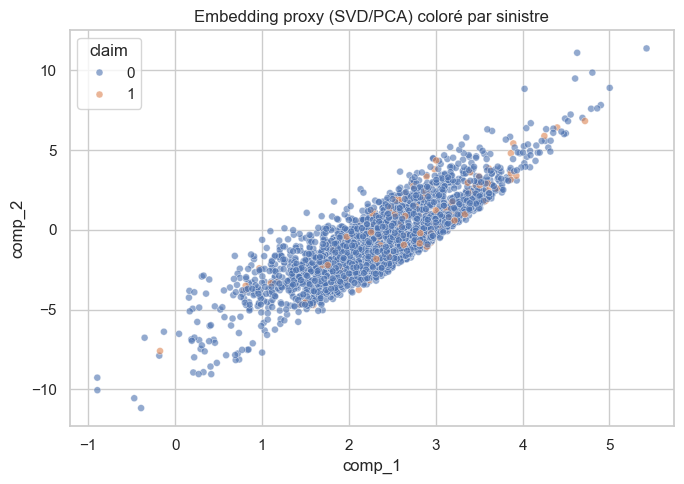

In [16]:
# Réduction de dimension proxy FAMD/MCA (sans dépendance externe)
sample_df = sample_for_exploration(train_fe, n=SAMPLE_N, seed=SEED, stratify_col="type_contrat" if "type_contrat" in train_fe.columns else None)
sample_num = [c for c in sample_df.columns if str(sample_df[c].dtype).startswith(("int","float")) and c not in [v2.TARGET_FREQ_COL, v2.TARGET_SEV_COL]]
sample_cat = [c for c in sample_df.columns if sample_df[c].dtype == "object"]
emb = fit_mixed_embedding_proxy(sample_df, num_cols=sample_num, cat_cols=sample_cat, n_components=2)
emb_plot = emb.copy()
emb_plot["claim"] = (sample_df[v2.TARGET_SEV_COL].astype(float) > 0).astype(int).values
emb_plot["utilisation"] = sample_df["utilisation"].astype(str).values if "utilisation" in sample_df.columns else "NA"
emb_plot["type_contrat"] = sample_df["type_contrat"].astype(str).values if "type_contrat" in sample_df.columns else "NA"

plt.figure(figsize=(7,5))
sns.scatterplot(data=emb_plot, x="comp_1", y="comp_2", hue="claim", alpha=0.6, s=25)
plt.title("Embedding proxy (SVD/PCA) coloré par sinistre")
plt.tight_layout()


In [17]:
# Clustering exploratoire (KMeans) sur représentation mixte encodée
from src.ds_analysis_utils import fit_kmeans_exploration

sample_num = [c for c in sample_df.columns if str(sample_df[c].dtype).startswith(("int","float")) and c not in [v2.TARGET_FREQ_COL, v2.TARGET_SEV_COL]]
sample_cat = [c for c in sample_df.columns if sample_df[c].dtype == "object"]
kmeans_df = fit_kmeans_exploration(sample_df, num_cols=sample_num, cat_cols=sample_cat, n_clusters=4, random_state=SEED)
sample_cluster = sample_df.join(kmeans_df)
cluster_summary = sample_cluster.groupby("cluster").agg(
    n=(v2.TARGET_SEV_COL, "size"),
    claim_rate=(v2.TARGET_SEV_COL, lambda s: float((pd.to_numeric(s, errors='coerce') > 0).mean())),
    pure_premium_obs=(v2.TARGET_SEV_COL, lambda s: float(pd.to_numeric(s, errors='coerce').fillna(0).mean())),
).reset_index()
display(cluster_summary)


,cluster,n,claim_rate,pure_premium_obs
0,0,801,0.052434,111.436155
1,1,519,0.102119,169.743179
2,2,569,0.029877,47.158120
3,3,1111,0.051305,94.232682


In [18]:
# Gower-like (custom) + CAH sur petit échantillon (coût O(n²))
n_gower = 300 if QUICK_ANALYSIS else 800
gower_sample = sample_for_exploration(sample_df, n=n_gower, seed=SEED, stratify_col=None)
g_num = [c for c in gower_sample.columns if str(gower_sample[c].dtype).startswith(("int","float")) and c not in [v2.TARGET_FREQ_COL, v2.TARGET_SEV_COL]]
g_cat = [c for c in gower_sample.columns if gower_sample[c].dtype == "object"]
D = compute_gower_like_distance_sample(gower_sample, num_cols=g_num, cat_cols=g_cat)
print("distance matrix shape:", D.shape, "mean dist:", float(np.mean(D)))
link = compute_linkage_from_distance(D, method="average")
print("linkage shape:", link.shape)


distance matrix shape: (300, 300) mean dist: 0.42355268726464096
linkage shape: (299, 4)


**À commenter (segmentation / mining)**
- `Constat`: structures/amas potentiels dans les données mixtes.
- `Interprétation`: exploration descriptive, pas segmentation de production.
- `Décision`: réutiliser les patterns pour enrichir les features/segments métier.


In [19]:
# Mapping preprocessing + recommandations
missing_report = compute_missingness_report(train_raw, test_raw, group_cols=None)
prep_reco = compute_preprocessing_recommendations(data_dict, cardinality, missing_report)
display(prep_reco.head(50))


,column,action,encoding,imputation,scaling,transform,comment
0,id_client,exclude_feature,none,none,none,none,TE uniquement en CV cross-fit; IDs exclus; fea...
1,id_contrat,exclude_feature,none,none,none,none,TE uniquement en CV cross-fit; IDs exclus; fea...
2,id_vehicule,exclude_feature,none,none,none,none,TE uniquement en CV cross-fit; IDs exclus; fea...
3,index,exclude_feature,none,none,none,none,TE uniquement en CV cross-fit; IDs exclus; fea...
4,montant_sinistre,target_only,none,none,none,none,TE uniquement en CV cross-fit; IDs exclus; fea...
5,nombre_sinistres,target_only,none,none,none,none,TE uniquement en CV cross-fit; IDs exclus; fea...
6,age_conducteur1,use_feature,numeric,none_or_median,robust_scaler_if_distance_or_linear_model,none_or_binning_if_explainability,TE uniquement en CV cross-fit; IDs exclus; fea...
7,age_conducteur2,use_feature,numeric,none_or_median,robust_scaler_if_distance_or_linear_model,none_or_binning_if_explainability,TE uniquement en CV cross-fit; IDs exclus; fea...
8,anciennete_info,use_feature,numeric,none_or_median,robust_scaler_if_distance_or_linear_model,none_or_binning_if_explainability,TE uniquement en CV cross-fit; IDs exclus; fea...
9,anciennete_permis1,use_feature,numeric,none_or_median,robust_scaler_if_distance_or_linear_model,none_or_binning_if_explainability,TE uniquement en CV cross-fit; IDs exclus; fea...


In [20]:
# Catalogue de feature engineering (features existantes + blocs)
train_fe_v2, test_fe_v2 = v2.add_engineered_features_v2(train_raw, test_raw, rare_min_count=30)
fe_catalog = build_feature_engineering_catalog(train_fe_v2)
display(fe_catalog.head(100))


,feature,feature_block,rationale
0,bonus,contract_usage,feature brute utile au scoring
1,bonus_x_usage,contract_usage,interaction metier non lineaire
2,duree_contrat,contract_usage,feature brute utile au scoring
3,freq_paiement,contract_usage,feature brute utile au scoring
4,is_paiement_yes,contract_usage,signal binaire / gestion missing / OOD
5,paiement,contract_usage,feature brute utile au scoring
6,type_contrat,contract_usage,feature brute utile au scoring
7,utilisation,contract_usage,feature brute utile au scoring
8,age_conducteur1,driver,feature brute utile au scoring
9,age_conducteur2,driver,feature brute utile au scoring


In [21]:
# Ablations via artefacts V2 (si disponibles)
fs_cmp_path = ARTIFACT_V2 / "feature_set_comparison_v2.csv"
if fs_cmp_path.exists():
    fs_cmp = pd.read_csv(fs_cmp_path)
    display(fs_cmp.sort_values(["rmse_prime","q99_ratio_pos"], ascending=[True, False]).head(30))
else:
    print("Artifact absent:", fs_cmp_path)


,level,split,feature_set,engine,family,config_id,seed,severity_mode,calibration,tail_mapper,fold_id,n_valid,rmse_prime,auc_freq,brier_freq,rmse_sev_pos,q99_ratio_pos,run_id
2,run,secondary_group,base_v2,catboost,two_part_classic,cb_v2_c1,42,classic,none,isotonic,-1,50000,541.957024,0.651965,0.054078,1455.708350,0.320485,base_v2|catboost|two_part_classic|cb_v2_c1|42|...
15,run,secondary_group,compact_v2,catboost,two_part_classic,cb_v2_c1,42,classic,isotonic,isotonic,-1,50000,541.986967,0.648802,0.054098,1457.904565,0.297023,compact_v2|catboost|two_part_classic|cb_v2_c1|...
14,run,secondary_group,compact_v2,catboost,two_part_classic,cb_v2_c1,42,classic,none,isotonic,-1,50000,541.988166,0.652013,0.054063,1457.904565,0.297023,compact_v2|catboost|two_part_classic|cb_v2_c1|...
8,run,secondary_group,robust_v2,catboost,two_part_classic,cb_v2_c1,42,classic,none,isotonic,-1,50000,541.988261,0.650939,0.054077,1457.793302,0.287543,robust_v2|catboost|two_part_classic|cb_v2_c1|4...
9,run,secondary_group,robust_v2,catboost,two_part_classic,cb_v2_c1,42,classic,isotonic,isotonic,-1,50000,542.032302,0.646577,0.054123,1457.793302,0.287543,robust_v2|catboost|two_part_classic|cb_v2_c1|4...
3,run,secondary_group,base_v2,catboost,two_part_classic,cb_v2_c1,42,classic,isotonic,isotonic,-1,50000,542.083295,0.646871,0.054116,1455.708350,0.320485,base_v2|catboost|two_part_classic|cb_v2_c1|42|...
16,run,aux_blocked5,compact_v2,catboost,two_part_classic,cb_v2_c1,42,classic,none,isotonic,-1,50000,542.253302,0.645036,0.054159,1459.179174,0.300804,compact_v2|catboost|two_part_classic|cb_v2_c1|...
10,run,aux_blocked5,robust_v2,catboost,two_part_classic,cb_v2_c1,42,classic,none,isotonic,-1,50000,542.413466,0.644453,0.054169,1462.087731,0.301773,robust_v2|catboost|two_part_classic|cb_v2_c1|4...
11,run,aux_blocked5,robust_v2,catboost,two_part_classic,cb_v2_c1,42,classic,isotonic,isotonic,-1,50000,542.434331,0.641505,0.054174,1462.087731,0.301773,robust_v2|catboost|two_part_classic|cb_v2_c1|4...
17,run,aux_blocked5,compact_v2,catboost,two_part_classic,cb_v2_c1,42,classic,isotonic,isotonic,-1,50000,542.583132,0.641581,0.054260,1459.179174,0.300804,compact_v2|catboost|two_part_classic|cb_v2_c1|...


In [22]:
# Exports d'analyse (Notebook 2)
segment_exports = {f"segment_target_{k}": v for k, v in seg_tables.items()}
tables = {
    "preprocessing_recommendations": prep_reco,
    "feature_engineering_catalog": fe_catalog,
    "cardinality_report": cardinality,
    **segment_exports,
}
export_analysis_tables(tables, ARTIFACT_DS)
print("Exports DS notebook 2 ->", ARTIFACT_DS)


Exports DS notebook 2 -> c:\Users\icemo\Downloads\Calcul-prime-d-assurance\artifacts\ds


## Synthèse Notebook 2 (à compléter)

- Features / transformations retenues:
  - [ ] ...
- Features / transformations rejetées (et pourquoi):
  - [ ] ...
- Prochaines validations côté modèle:
  - [ ] queue de sévérité
  - [ ] calibration fréquence
  - [ ] biais par segment
